In [63]:
from enum import Enum

import pandas as pd
import numpy as np

import os
import cv2
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import csv
%matplotlib inline

from PIL import Image
import gc

sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [9]:
import torch
import torchvision
import tarfile
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tt

from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets.utils import download_url

In [10]:
from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient

In [11]:
# Setting up the data from the bucket

connection_string = os.getenv('AZURE_CONNECTION_STRING')
container_train_name = "epitech-zoidberg-dataset-train"
container_val_name = "epitech-zoidberg-dataset-validation"
container_test_name = "epitech-zoidberg-dataset-test"


blob_service_client = BlobServiceClient.from_connection_string(connection_string)

In [12]:
class EOutput(Enum):
  NEGATIVE = 0
  BACTERIA = 1
  VIRUS = 2

class EDataset(Enum):
  TRAIN = 0
  VALIDATION = 1
  TEST = 2

In [13]:
train_tfms = tt.Compose([
                        #  tt.RandomCrop(250, padding=10, padding_mode='reflect'),
                         tt.RandomHorizontalFlip(),
                         tt.RandomRotation([-10, 10]),
                         tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
                         tt.ToTensor(),
                         ])

valid_tfms = tt.ToTensor()

In [14]:
# Download images from Azure Storage Account

def load_blob_from_container(container_name, dataset_type):
    images = []
    labels = []

    container_client = blob_service_client.get_container_client(container_name)
    blobs = container_client.list_blobs()

    for blob in blobs:

        blob_client = blob_service_client.get_blob_client(container_name, blob.name)
        stream = blob_client.download_blob().readall()

        nparr = np.frombuffer(stream, np.uint8)

        img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

        if img is None: continue

        img = cv2.resize(img, (200,200))

        if dataset_type == EDataset.TRAIN:
            images.append(
                train_tfms(Image.fromarray(img))
            )
        else:
            images.append(
                valid_tfms(Image.fromarray(img))
            )

        if "bacteria" in blob.name:
            labels.append(EOutput.BACTERIA.value)
            continue

        if "virus" in blob.name:
            labels.append(EOutput.VIRUS.value)
            continue

        labels.append(EOutput.NEGATIVE.value)

    return list(zip(images, labels))

In [15]:
train_ds = load_blob_from_container(container_name=container_train_name, dataset_type=EDataset.TRAIN)
val_ds = load_blob_from_container(container_name=container_val_name, dataset_type=EDataset.VALIDATION)
test_ds = load_blob_from_container(container_name=container_test_name, dataset_type=EDataset.TEST)

In [16]:
print(f"Train dataset size: {len(train_ds)}")
print(f"Validation dataset size: {len(val_ds)}")
print(f"Test dataset size: {len(test_ds)}")

Train dataset size: 4684
Validation dataset size: 586
Test dataset size: 585


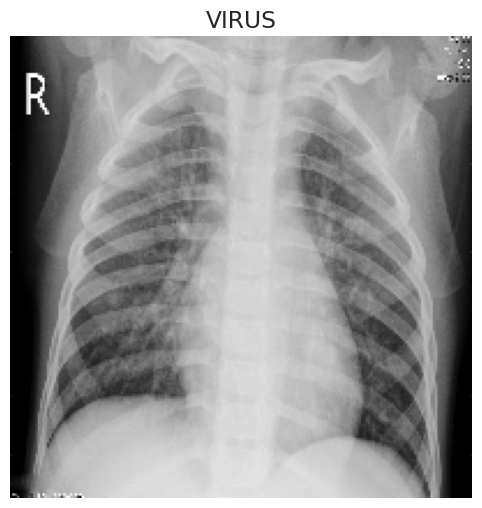

In [21]:
image, label = test_ds[np.random.randint(0, len(test_ds))]

plt.imshow(image.permute(1, 2, 0))
plt.title(EOutput(label).name)
plt.axis('off')
plt.show()

In [22]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

In [23]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [24]:
def conv_block(in_channels, out_channels, pool=False):
  layers = [
      nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, ),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True),
  ]
  if pool: layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers)

class ResidualBlock(nn.Module):
  def __init__(self, channels):
    super(ResidualBlock, self).__init__()
    self.conv = nn.Sequential(
      conv_block(channels, channels),
      conv_block(channels, channels)
    )

  def forward(self, x):
    return self.conv(x) + x

class ResNet9(ImageClassificationBase):
  def __init__(self, in_channels, num_classes):
    super().__init__()

    self.conv = nn.Sequential(
        conv_block(in_channels, 256),
        conv_block(256, 512, pool=True),
        ResidualBlock(512),

        conv_block(512, 1024, pool=True),
        conv_block(1024, 2048, pool=True),
        ResidualBlock(2048),

        nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(2048, num_classes)
        )
    )

  def forward(self, xb):
    return self.conv(xb)

In [25]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):

    torch.cuda.empty_cache()
    history = []

    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)

    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        model.train()
        train_losses = []
        lrs = []

        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            if grad_clip:
              nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()

            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lr'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [26]:
batch_size = 18
input_layer = 250*250

In [27]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, shuffle=True, num_workers=3, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/home/dany_leguy/miniconda/envs/jupyter/lib/python3.11/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [28]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
model = to_device(ResNet9(3, 3), device)
history = [evaluate(model, valid_dl)]
history[0]["train_loss"] = 0

In [29]:
%%time
history += fit_one_cycle(
    epochs=5,
    max_lr=0.01,
    model=model,
    train_loader=train_dl,
    val_loader=valid_dl,
    weight_decay=1e-4,
    grad_clip=.1,
    opt_func=torch.optim.Adam
)

Epoch [0], train_loss: 0.9858, val_loss: 0.9485, val_acc: 0.5905
Epoch [1], train_loss: 0.9515, val_loss: 1.3357, val_acc: 0.4830
Epoch [2], train_loss: 0.8740, val_loss: 1.0831, val_acc: 0.5020
Epoch [3], train_loss: 0.7718, val_loss: 0.8379, val_acc: 0.6029
Epoch [4], train_loss: 0.6578, val_loss: 0.6962, val_acc: 0.6807
CPU times: user 1h 9min 3s, sys: 59min 19s, total: 2h 8min 22s
Wall time: 2h 8min 15s


In [30]:
%%time
history += fit_one_cycle(
    epochs=5,
    max_lr=0.01,
    model=model,
    train_loader=train_dl,
    val_loader=valid_dl,
    weight_decay=1e-4,
    grad_clip=.1,
    opt_func=torch.optim.Adam
)

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.75 GiB. GPU 0 has a total capacity of 14.58 GiB of which 2.54 GiB is free. Including non-PyTorch memory, this process has 12.04 GiB memory in use. Of the allocated memory 5.33 GiB is allocated by PyTorch, and 5.67 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [31]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

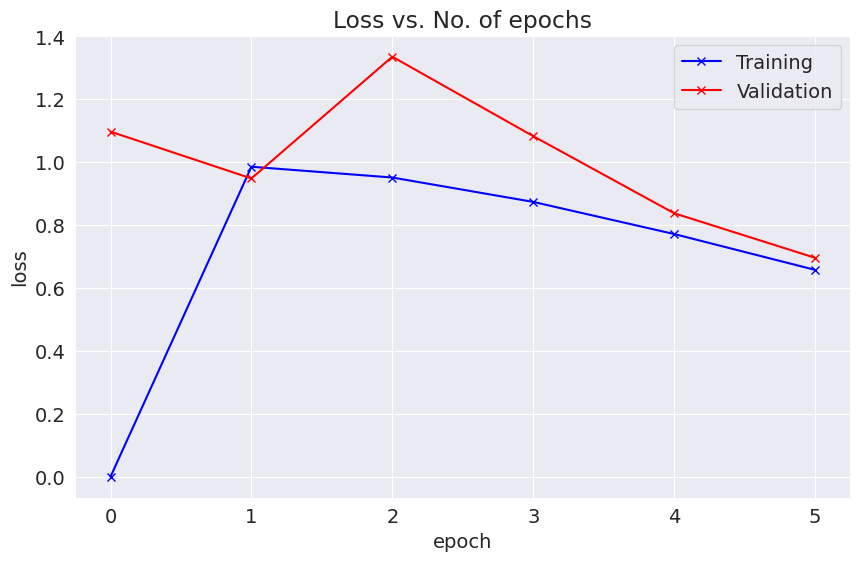

In [87]:
plot_losses(history)

In [ ]:
model = model.to("cpu")

In [ ]:
image, label = test_ds[np.random.randint(0, len(test_ds))]

plt.imshow(image.permute(1, 2, 0))
plt.title(EOutput(label).name)

pred = model(to_device(image.unsqueeze(0), device))

print(f"Label: {EOutput(label).name}, prediction: {EOutput(torch.max(pred, dim=1)[1].item()).name}")

plt.axis('off')

plt.show()

In [85]:
file_meta_data = [("val_loss", "val_acc", "train_loss")]
file_data_csv = [(i["val_loss"], i["val_acc"], i["train_loss"]) for i in history]

full_file = file_meta_data + file_data_csv

[('val_loss', 'val_acc', 'train_loss'), (1.09743070602417, 0.369934618473053, 0), (0.9485233426094055, 0.5905228853225708, 0.9857568144798279), (1.3356800079345703, 0.4830065369606018, 0.9515312314033508), (1.0831036567687988, 0.5019607543945312, 0.8739594221115112), (0.8379160761833191, 0.6029411554336548, 0.7718311548233032), (0.6962230205535889, 0.6807188987731934, 0.6578040719032288)]


In [86]:
path = os.path.join(os.getcwd(), "fileName.csv")
print(path)
with open(path, "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerows(full_file)

[{'val_loss': 1.09743070602417, 'val_acc': 0.369934618473053, 'train_loss': 0}, {'val_loss': 0.9485233426094055, 'val_acc': 0.5905228853225708, 'train_loss': 0.9857568144798279, 'lr': [0.0003999999999999993, 0.00040015533401515854, 0.000400621326007029, 0.0004013979458154394, 0.00040248514317561303, 0.0004038828477214082, 0.00040559096898988567, 0.0004076093964271565, 0.0004099379993955342, 0.0004125766271820038, 0.0004155251090079571, 0.0004187832540402635, 0.00042235085140361096, 0.00042622767019415315, 0.00043041345949446433, 0.0004349079483897695, 0.00043971084598548073, 0.00044482184142603104, 0.00045024060391498505, 0.0004559667827364524, 0.0004620000072777866, 0.00046833988705357807, 0.00047498601173091674, 0.00048193795115595434, 0.0004891952553817483, 0.0004967574546973809, 0.0005046240596583585, 0.0005127945611182912, 0.0005212684302618488, 0.0005300451186389804, 0.0005391240582004169, 0.0005485046613344351, 0.0005581863209048916, 0.0005681684102905107, 0.0005784502834254527,

In [59]:
model_file_name = "yourFileName.pth"
model_path = os.path.join(os.getcwd(), mode_file_name)

In [ ]:
torch.save(model.state_dict(), model_path)

In [ ]:
model.load_state_dict(torch.load(model_path))

In [58]:
# Checks if you have the permissions to write in this folder.
try:
    with open(os.path.join(os.getcwd(), 'temp.txt'), 'w') as f:
        pass
    print("Write permissions check passed.")
except:
    print("Write permissions check failed.")

True
Write permissions check passed.
